In [1]:
# demo From Network
import tensorflow as tf
from tensorflow.keras import backend as K
print(tf.test.is_gpu_available())

--AA
AA--
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [2]:
import tensorflow as tf
import os
from glob import glob
# !pip install -q tensorflow-io
import tensorflow_io as tfio


from matplotlib import pyplot as plt

from IPython import display
import imageio

import numpy as np
import math
import tensorflow.keras.preprocessing.image as prep


from copy import copy
import matplotlib.colors as colors
import matplotlib.image as mpimg

None
--AA
AA--


## Hyperparameters

In [3]:
# ## dataset paths
train_images = sorted(glob('E:\\dataset\\SublingualVein\\TIASRGB2020\\inputs/*'))
train_masks = sorted(glob('E:\\dataset\\SublingualVein\\TIASRGB2020\\selected_masks\\raw/*'))
test_images = sorted(glob('E:\\dataset\\SublingualVein\\TIASRGB2020\\val/*'))
test_masks = sorted(glob('E:\\dataset\\SublingualVein\\TIASRGB2020\\val_selected_masks\\raw/*'))


# ## dataset paths in labe windows
# train_images = sorted(glob('F:\\dataset\\TIASRGB2020\\lab_dataset\\inputs/*'))
# train_masks = sorted(glob('F:\\dataset\\TIASRGB2020\\lab_dataset\\selected_masks\\raw/*'))
# test_images = sorted(glob('F:\\dataset\\TIASRGB2020\\lab_dataset\\val/*'))
# test_masks = sorted(glob('F:\\dataset\\TIASRGB2020\\lab_dataset\\val_selected_masks\\raw/*'))

# input info
# raw TIAS INPUT SIZE 1080X1920
raw_w = 1080
raw_h =  1920
# resize_factor =  4
# img_w =  raw_w // resize_factor 
# img_h =  raw_h // resize_factor
img_w =  224
img_h =  224 # Pretrained Keras model MobileNetV2 only accept the following input dimensions: [96, 128, 160, 192, 224] 

print("desired img w:", img_w)
print("desired img h:", img_h)


# parameters for model
BATCH_SIZE = 4
OUTPUT_CHANNELS = 3

desired img w: 224
desired img h: 224


## dataset and preprocess


tf.Tensor(b'E:\\dataset\\SublingualVein\\TIASRGB2020\\inputs\\1002dozono01 (1).bmp', shape=(), dtype=string)
tf.Tensor(b'E:\\dataset\\SublingualVein\\TIASRGB2020\\selected_masks\\raw\\1002dozono01 (1).png', shape=(), dtype=string)
inputs shape: (224, 224, 3)
masks shape: (224, 224, 3)
inputs shape: (224, 224, 3)
masks shape: (224, 224, 3)
input_image.shape (224, 224, 3)
seg_label.shape (224, 224, 3)



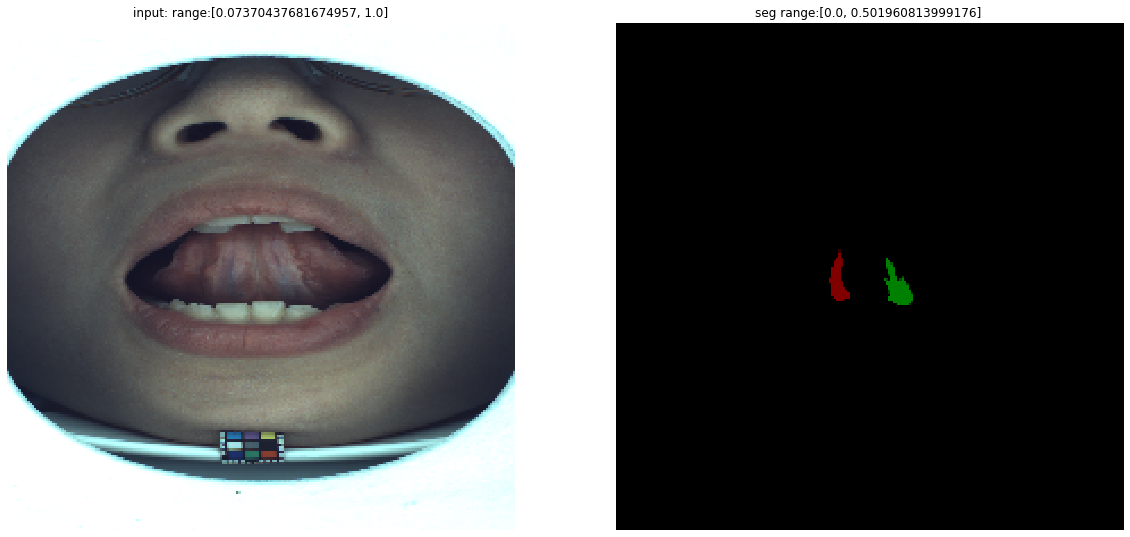

In [4]:
##  pre-processing funcs define
# # check the dataset
def plot_input_and_mask(img, seg_label):
#     palette = copy(plt.cm.gray)
#     palette.set_over('r', 1.0)
#     print("dicom_path:", dicom_path)
    print("input_image.shape", img.numpy().shape)
    print("seg_label.shape", seg_label.numpy().shape)

    fig, axes = plt.subplots(1,2, figsize=(20,20))
    
    print()
    axes[0].imshow(img)
    axes[0].set_title('input: range:[{}, {}]'.format((np.min(img)), np.max(img)))
    axes[0].axis('off')
    axes[1].imshow(seg_label)
    axes[1].set_title('seg range:[{}, {}] '.format(np.min(seg_label), np.max(seg_label)))
    axes[1].axis('off')
    

def decode_img(img_bytes, img_type="bmp"):
    # conver compuresed string to a 3D unit8 tensor
    if img_type == "bmp":
        img = tf.io.decode_bmp(img_bytes, channels=3)
    else:
        img =tf.io.decode_png(img_bytes, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)  # this will nomrlize within (0 , max)
    # resize the image to the desired size.
    return tf.image.resize(img, [img_h, img_w])  # A 1-D int32 Tensor of 2 elements: new_height, new_width. The new size for the images.
    
    
    
def load_image(image_path, img_type = "bmp"):
    img_bytes = tf.io.read_file(image_path)
    decoded_img = decode_img(img_bytes, img_type)
    return decoded_img


def train_process_func(image_path, mask_path):
    # load input
    inputs =  load_image(image_path, "bmp")
    print("inputs shape:", inputs.shape)
    # load mask 
    masks = load_image(mask_path, "png")
    print("masks shape:", masks.shape)
    return inputs, masks

def test_process_func(image_path, mask_path):
    # load input
    inputs =  load_image(image_path, "bmp")
    print("inputs shape:", inputs.shape)
    # load mask 
    masks = load_image(mask_path, "png")
    print("masks shape:", masks.shape)
    return inputs, masks

# genrate dataset from dataset paths
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))       
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))  
# check the train_dataset from the paths
print("")
for data in train_dataset.take(1):
    print(data[0])
    print(data[1])

train_dataset = train_dataset.shuffle(300)
# train_dataset = train_dataset.map(map_func=train_process_func,
#                                   num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE).repeat()    #
train_dataset = train_dataset.map(map_func=train_process_func,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)  # if use for lop directly on the dataset no repeat()

test_dataset = test_dataset.map(map_func=test_process_func,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)   

# check the train image
for inputs, masks in train_dataset.take(1):
    plot_input_and_mask(inputs[0], masks[0])

## model design

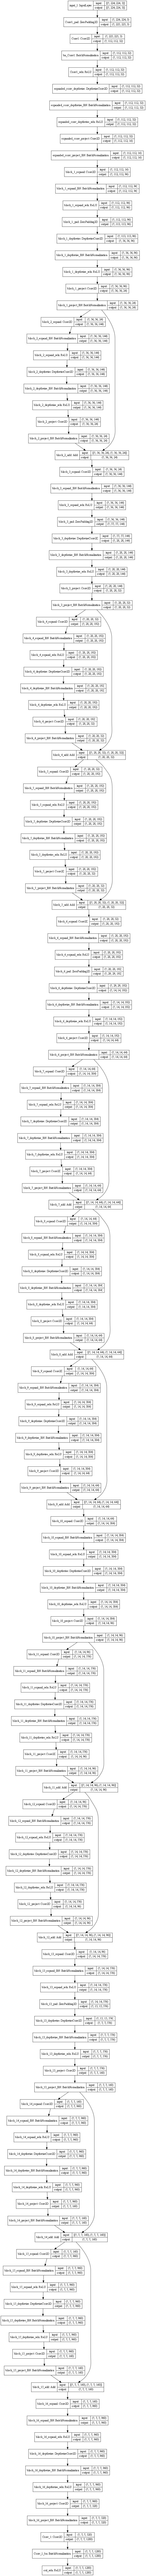

In [5]:
# BASE MODEL
base_model = tf.keras.applications.MobileNetV2(input_shape=[img_h, img_w, 3], include_top=False)
tf.keras.utils.plot_model(base_model, to_file="base_MobileNetV2.png", show_shapes=True, dpi=64)

layers: [<tf.Tensor 'block_1_expand_relu/Identity:0' shape=(None, 112, 112, 96) dtype=float32>, <tf.Tensor 'block_3_expand_relu/Identity:0' shape=(None, 56, 56, 144) dtype=float32>, <tf.Tensor 'block_6_expand_relu/Identity:0' shape=(None, 28, 28, 192) dtype=float32>, <tf.Tensor 'block_13_expand_relu/Identity:0' shape=(None, 14, 14, 576) dtype=float32>, <tf.Tensor 'block_16_project/Identity:0' shape=(None, 7, 7, 320) dtype=float32>]


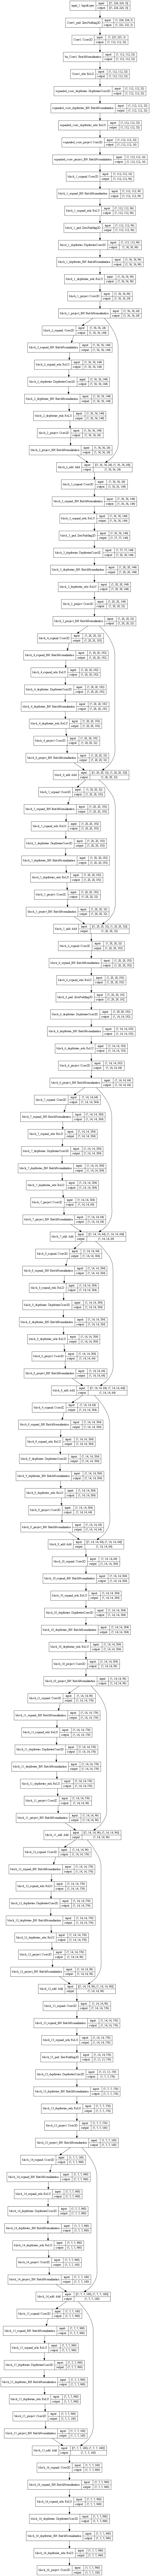

In [6]:
# Use the activations of these layers. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]
print('layers:', layers)
# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False
tf.keras.utils.plot_model(down_stack, to_file="down_stack.png", show_shapes=True, dpi=64)

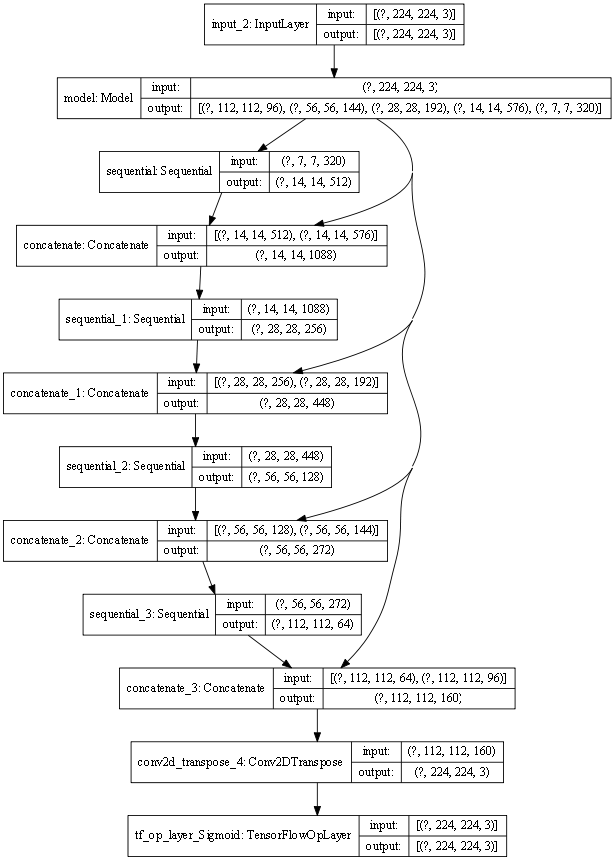

In [7]:
# The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
          tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]


def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[img_h, img_w, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)
    
    x =  tf.sigmoid(x)

    return tf.keras.Model(inputs=inputs, outputs=x)
MobileNetV2UNet = unet_model(OUTPUT_CHANNELS)
tf.keras.utils.plot_model(MobileNetV2UNet, to_file="U-NET.png", show_shapes=True, dpi=64)

## prepare training

In [8]:
# project_name
project_name = "1MobileNetV2_UNet_SubligualSeg/"
if not os.path.exists(project_name):
    os.makedirs(project_name)
# tb_log_name 
log_dir=project_name + "AE_logs/"

# image_save name
train_save_figure_path = project_name + "AE_saves/train"
test_save_figure_path = project_name + "AE_saves/test"

# training_checkpoint name
checkpoint_dir = project_name + "training_checkpoints"

# -------------------------------------------------------------------------->

## get current working directory
cwd = os.getcwd()
print("current working directory:", cwd)
train_full_AE_saves =  os.path.join(cwd, train_save_figure_path)
test_full_AE_saves =  os.path.join(cwd, test_save_figure_path)
print("train_full_AE_saves:", train_full_AE_saves)
print("test_full_AE_saves:", test_full_AE_saves)


if not os.path.exists(train_full_AE_saves):
    os.makedirs(train_full_AE_saves)

if not os.path.exists(test_full_AE_saves):
    os.makedirs(test_full_AE_saves)
    
    
train_predictions_save_path =os.path.join(train_full_AE_saves, "Predictions")
# train_clsDistr_save_path =os.path.join(train_full_AE_saves, "ClassDistruibution")

test_predictions_save_path =os.path.join(test_full_AE_saves, "Predictions")

# test_confusion_matrix =  os.path.join(test_full_AE_saves, "Confusion_Matrix")
# test_cm_diags =  os.path.join(test_full_AE_saves, "Confusion_Matrix_diagnoise_with_Epoch")

# test_batch_losses =  os.path.join(test_full_AE_saves, "Test_batch_losses")

test_EpochValidation_save_path =os.path.join(test_full_AE_saves, "EpochValidation")
# test_EpochValidation_save_path_pred =os.path.join(test_EpochValidation_save_path, "PredictionsOnly")
if not os.path.exists(train_predictions_save_path):
    os.makedirs(train_predictions_save_path)
# if not os.path.exists(train_clsDistr_save_path):
#     os.makedirs(train_clsDistr_save_path)
    
if not os.path.exists(test_predictions_save_path):
    os.makedirs(test_predictions_save_path)
if not os.path.exists(test_EpochValidation_save_path):
    os.makedirs(test_EpochValidation_save_path)
# if not os.path.exists(test_EpochValidation_save_path_pred):
#     os.makedirs(test_EpochValidation_save_path_pred)   
# if not os.path.exists(test_confusion_matrix):
#     os.makedirs(test_confusion_matrix)       
# if not os.path.exists(test_cm_diags):
#     os.makedirs(test_cm_diags) 
# if not os.path.exists(test_batch_losses):
#     os.makedirs(test_batch_losses)   
    
#     plt.show()

# 
import datetime

# for tensorboard writers
datetime_rec =  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_summary_writer = tf.summary.create_file_writer(
  log_dir + "train")
val_summary_writer = tf.summary.create_file_writer(
  log_dir + "val")

%load_ext tensorboard
%tensorboard --logdir {log_dir}

current working directory: E:\Projects\TF2\SublingualVein\2020May
train_full_AE_saves: E:\Projects\TF2\SublingualVein\2020May\1MobileNetV2_UNet_SubligualSeg/AE_saves/train
test_full_AE_saves: E:\Projects\TF2\SublingualVein\2020May\1MobileNetV2_UNet_SubligualSeg/AE_saves/test


Reusing TensorBoard on port 6006 (pid 30492), started 14:22:45 ago. (Use '!kill 30492' to kill it.)

In [9]:
# design new loss for the new model as new_train_step, new_test_step
# new_optimizer =  tf.keras.optimizers.Adam(1e-4)
# from tf.keras.utils import to_categorical
# BCE =  tf.keras.losses.BinaryCrossentropy() 
# Huber =  tf.keras.losses.Huber(delta=0.1)
# SCC = tf.keras.losses.SparseCategoricalCrossentropy()

@tf.function
def dice_coef(y_true, y_pred, smooth=1, input_type="RGB"):
    if input_type == "RGB":
        y_true =  tf.image.rgb_to_grayscale(y_true)
        y_pred = tf.image.rgb_to_grayscale(y_pred)
        
    else: pass
    y_true =  tf.cast(tf.math.greater(y_true, 0), tf.float32)
    y_pred =  tf.cast(tf.math.greater(y_pred, 0), tf.float32)
    print("y_true.shape", y_true.shape)
    print("y_pred.shape",y_pred.shape)
    
    intersection = tf.math.reduce_sum(y_true * y_pred)
    union = tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_pred)
    dice = tf.reduce_mean((2. * intersection + smooth)/(union + smooth))
    return dice

@tf.function
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def Smooth_l1_loss(labels,predictions):
    diff=tf.abs(labels-predictions)
    less_than_one=tf.cast(tf.less(diff,1.0),tf.float32)   #Bool to float32
    smooth_l1_loss=(less_than_one*0.5*diff**2)+(1.0-less_than_one)*(diff-0.5)#同上图公式
    return tf.reduce_mean(smooth_l1_loss)

@tf.function()
# define losses
def new_compute_loss(pred, seg_label):
    
#     #seg  cross_entropy,  use reduce mean not sum, otherwise loss will be very big
#     cls_BCE_loss1 = BCE(y_true=cls_tars[0], y_pred=preds[0]) 
#     cls_BCE_loss2 = BCE(y_true=cls_tars[1], y_pred=preds[1]) 
    L1_smooth_loss = Smooth_l1_loss(seg_label, pred) 
    total_loss = L1_smooth_loss
#     # L1 loss 
# #     L1_loss = tf.reduce_mean(tf.abs(x - decoded_x))
    
#     #seg Huber_loss
#     seg_Huber_loss = Huber(y_true=gt_seg, y_pred=pred_seg)
    
#     seg_total_loss = seg_Huber_loss + seg_BCE_loss
    
    
#     # use tf.keras.losses.SparseCategoricalCrossentropy instead of BCE , no need one-hot tranfermat
#     cls_SCC_loss=  SCC(y_true=gt_cls, y_pred=pred_cls)
    
#     # total_loss = cls_BCE_loss + seg_loss
#     total_loss = cls_SCC_loss 
    return total_loss
    

@tf.function()
def new_train_step(model, optimizer, inputs, seg_target, training):
    # change cls labe 0 or 1 into  [1, 0] [0, 1]
#     print(cls_target)
#     cls_target = mask_to_categorical(cls_target)
#     print("in trianing step")
    with tf.GradientTape() as tape:  # very interesting
        # outputs=[seg_out, class_sigmoid_output] 
        pred= model(inputs, training=training)
        total_loss = new_compute_loss(pred=pred, seg_label=seg_target)
        dice = dice_coef(seg_target, pred)
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, dice

@tf.function()
def new_test_step(model, inputs, seg_target, training):
    with tf.GradientTape() as tape:  # if use tf.function. needs to wrap the code with the same variable name otherwise non-first call value error
        pred= model(inputs, training=training)
        total_loss= new_compute_loss(pred=pred, seg_label=seg_target)
        dice = dice_coef(seg_target, pred)
    return total_loss, pred, dice

In [10]:
def check_predict_images(model, batch_input, batch_seg_target, batch_idx, epoch, save=True, Train_or_not=True, Epoch_val =False):
#     prediction = model(test_input, training=True)
  
    
    Seg_output = model.predict(batch_input)
#     print("class_sigmoid_output shape:", class_sigmoid_output)
    single_seg_pred =  Seg_output[0]
    single_input =batch_input[0].numpy()
    single_seg_label =batch_seg_target[0].numpy()
    
    fig, axes = plt.subplots(1,3, figsize=(15,15))
    
    eval_dice =  dice_coef(single_seg_label, single_seg_pred)
        
#     palette = copy(plt.cm.gray)
#     palette.set_over('r', 1.0)

    print("single_input.shape", single_input.shape)
    print("single_seg_label.shape", single_seg_label.shape)
    print("single_seg_pred.shape", single_seg_pred.shape)
#     num_nonzeros=np.count_nonzero(seg_label)
    # reshape label 
#     target =  tf.reshape(seg_label, norm_input.shape)
#     norm_mask =  np.squeeze(target.numpy())
#     norm_input = np.squeeze(norm_input.numpy())
#     norm_Seg_pred =  np.squeeze(Seg_pred.numpy())
#     print("norm_mask", norm_mask.shape)
#     print("norm_input", norm_input.shape)
#     masked_in = norm_w_input + norm_mask
#     print('masked_in range:[{}, {}]'.format((masked_in.min()), masked_in.max()))

#     masked = np.ma.masked_where(norm_mask==0, masked_in)  # this is only generated mask
#     print('masked range:[{}, {}]'.format(masked.min(), masked.max())) 

    axes[0].imshow(single_input)
    axes[0].set_title('input range:[{}, {}]'.format(np.min(single_input), np.max(single_input)))
    axes[1].imshow(single_seg_label)
    axes[1].set_title('label range:[{}, {}]'.format(np.min(single_seg_label), np.max(single_seg_label)))
    axes[2].imshow(single_seg_pred)             
    axes[2].set_title('pred. range:[{}, {}] \n dice: {}'.format(np.min(single_seg_pred), np.max(single_seg_pred), eval_dice))
#     axes.imshow(masked, palette, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)
    
    plt.tight_layout()
    
    if save==True :
        if Train_or_not:
            fig.savefig(train_save_figure_path + "/Train_image_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
        else:
            if Epoch_val:
                fig.savefig(test_EpochValidation_save_path + "/Test_image_at_epoch_{:04d}_batch_{}_idx.png".format(epoch,batch_idx))
            else:
                fig.savefig(test_save_figure_path + "/Test_image_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
     
    
    

y_true.shape (224, 224, 1)
y_pred.shape (224, 224, 1)
single_input.shape (224, 224, 3)
single_seg_label.shape (224, 224, 3)
single_seg_pred.shape (224, 224, 3)
single_input.shape (224, 224, 3)
single_seg_label.shape (224, 224, 3)
single_seg_pred.shape (224, 224, 3)


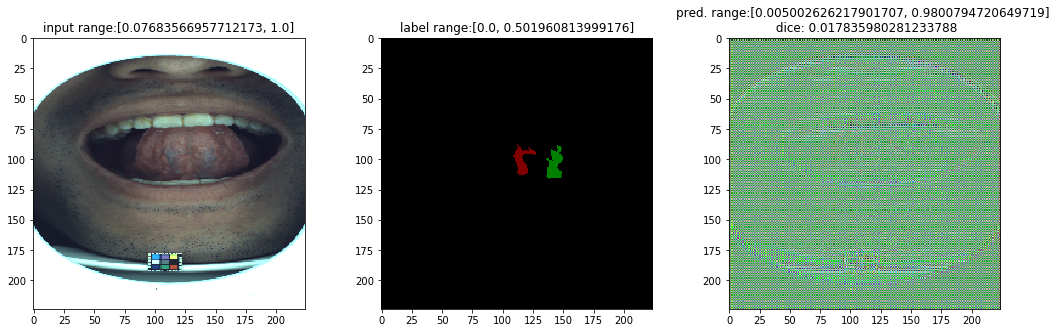

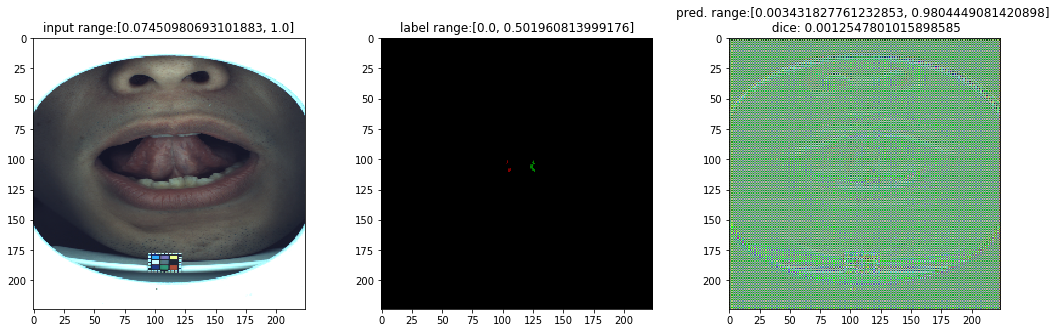

In [11]:
for batch_inputs,  batch_labels in train_dataset.take(2):
    check_predict_images(MobileNetV2UNet, batch_inputs, batch_labels, 1, 1, save=False, Train_or_not=True, Epoch_val =False)

In [12]:
def write_single_total_loss_tb(writer, avg_losses, name, epoch):
    """
     avg_losses = [total_loss, seg_loss, cls_loss]
    """
    with writer.as_default():
        print("writing train logs to tensorboard...")                                                       
        # write scalars to the tensorboard after each train step
        tf.summary.scalar(name, avg_losses.result(), step=epoch)
        
def write_single_scalar_tb(writer, avg_losses, name, epoch):
    """
     avg_losses = [total_loss, seg_loss, cls_loss]
    """
    with writer.as_default():
        print("writing train logs to tensorboard...")                                                       
        # write scalars to the tensorboard after each train step
        tf.summary.scalar(name, avg_losses, step=epoch)
        
def train_display_save_at(model, batch_inputs, batch_labels,  step, epoch, freq_step =200, save=True, Train_or_not=True):
    if step % freq_step ==0:
        print("train image checking----------------------------------------------------------------------------------->")
        check_predict_images(model, batch_inputs, batch_labels, step, epoch, save=save, Train_or_not=Train_or_not, Epoch_val =False)
        
def test_at_each_epoch(val_dataset, model, step, epoch, temp_dice, save=True, training=False):
    # initialize 
    epoch_val_flag = True
    # initialize for evaluating average metric
    test_total_loss_mean = tf.keras.metrics.Mean()
    test_total_dice_mean = tf.keras.metrics.Mean()
    count =0
    for test_batch_inputs, test_batch_labels in val_dataset:
        count+=1
        # one train step loss calculation and optimization  model2, inputs, cls_target, training
        te_total_loss, te_pred, te_dice = new_test_step(model, test_batch_inputs, test_batch_labels, training=False)
        test_total_loss_mean(te_total_loss)
        test_total_dice_mean(te_dice)
#         test_loss_catches.append(te_total_loss)

    
        print('[Test]Epoch: {} batch:{} \n  total_loss set loss: {}, avg dice： {}'.format(epoch, count, test_total_loss_mean.result(), test_total_dice_mean.result()))
        
        if count %25 ==0:
            display.clear_output(wait=True)
        
        


        check_predict_images(model, test_batch_inputs, test_batch_labels,step, epoch,  save=save, Train_or_not=training, Epoch_val=epoch_val_flag)                                               
#         display.clear_output(wait=True)

         
    epoch_val_flag = False # one epoch finish so set flag back
    
    
#     # write logs to tensorboard:    avg_losses = [total_loss, seg_loss, cls_loss]
#     # write test losses to the tensorboard
    print("writing test logs to tensorboard...") 
    write_single_total_loss_tb(val_summary_writer, test_total_loss_mean, "total_loss_per_epoch", epoch)
    write_single_total_loss_tb(val_summary_writer, test_total_dice_mean, "Avg_dice_per_epoch", epoch)
  
    # check whether needs to save the model
    if test_total_dice_mean.result() > temp_dice:
        save_path =  new_manager.save() # save the checkpoint and return the save path
        print("Saved checkpoint for epoch {}-  step {}: {}".format(epoch, step, save_path))
        temp_dice =  test_total_dice_mean.result()


# defin one epoch training for different dataset
def train_one_epoch(train_dataset, model, optimizer, step, epoch):
    #  initializations at each epoch 
    train_total_loss_mean = tf.keras.metrics.Mean()
    train_total_dice_mean = tf.keras.metrics.Mean()
    
    
    for tr_batch_inputs, tr_batch_labels in train_dataset:
 
        # one train step loss calculation and optimization
        tr_total_loss, tr_dice = new_train_step(model, optimizer, tr_batch_inputs, tr_batch_labels, training=True)
        train_total_loss_mean(tr_total_loss)
        train_total_dice_mean(tr_dice)
        
        if optimizer.iterations.numpy() % 10 == 0: 
            write_single_total_loss_tb(train_summary_writer, train_total_loss_mean, "train_total_loss_per_batch", optimizer.iterations.numpy())
            write_single_scalar_tb(train_summary_writer,  optimizer._decayed_lr(var_dtype=tf.float32), "Optimizer Lr", optimizer.iterations.numpy())
            write_single_scalar_tb(train_summary_writer,  train_total_dice_mean.result(), "Dice", optimizer.iterations.numpy())
        print('Epoch: {} batch:{} \n Train total_loss set loss: {}, train avg dice: {}'.format(epoch, int(step), train_total_loss_mean.result(), train_total_dice_mean.result()))
        
        #  model, Tr_dicom_paths, Tr_norm_input, Tr_norm_input_w_image, Tr_norm_seg_label,Tr_cls_label,   step, epoch, freq_step =100, save=True, Train_or_not=True
        train_display_save_at(model, tr_batch_inputs, tr_batch_labels,  int(step), epoch, freq_step =20, save=True, Train_or_not=True)

        if step % 25 ==0:
            display.clear_output(wait=True)


        step.assign_add(1)
        
    
     # write train epoch average loss to the tensorboard
    print("writing train logs to tensorboard...") 
    write_single_total_loss_tb(train_summary_writer, train_total_loss_mean, "total_loss_per_epoch", epoch)
    write_single_total_loss_tb(train_summary_writer, train_total_dice_mean, "Avg_dice_per_epoch", epoch)

In [13]:
# take_new_train_batches =  3035
def train_process(train_dataset, val_dataset, model, optimizer, step, start_epoch, total_epochs):
    # some initial parameters
    # test average_loss = for saving the test results
    test_avg_tmp_dice = 0

    for epoch in range(int(start_epoch), total_epochs+1):
      
    
        # train one epoch， including loss calculation and optimization
        train_one_epoch(train_dataset, model, optimizer, step, epoch)
        
        # one training epoch ended start to evaluate the performance through entire test dataset
        test_at_each_epoch(val_dataset, model, int(step), epoch, temp_dice=test_avg_tmp_dice, save=True, training = False)
      
      
        # when epoch fisnihed add epoch counter and reset the batch step 
        start_epoch.assign_add(1)     
        step.assign(1)
        
        
    # when training finihsed
    print("training finished") 

## train model

In [ ]:
import time
if __name__ == "__main__":
    
#     init_lr = 1e-3
#     learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
#       initial_learning_rate=init_lr,
#       decay_steps=1000,
#       end_learning_rate=0.0)
    learning_rate_fn = 1e-4
    new_optimizer =  tf.keras.optimizers.Adam(learning_rate_fn)
    # build_new check point manager
    new_ckpt_prefix = os.path.join(checkpoint_dir, "ckpt")
    if not os.path.exists(new_ckpt_prefix):
        os.makedirs(new_ckpt_prefix)
    #  contents of states to be saved as attributes on the checkpoint object
    new_ckpt_ob = tf.train.Checkpoint(step= tf.Variable(1),
                                        epoch=  tf.Variable(1),
                                        optimizer=new_optimizer,
                                         model =  MobileNetV2UNet
                                     )
    # define checkpoint manager
    new_manager =  tf.train.CheckpointManager(new_ckpt_ob, new_ckpt_prefix, max_to_keep=1)

    # check the whether there is a checkpoint in the checkpoint folder, if it is restore from it
    if new_manager.latest_checkpoint:
        print("Restored from {}".format(new_manager.latest_checkpoint))
        new_ckpt_ob.restore(new_manager.latest_checkpoint)
    else:
        print("Initializing from scratch.")

    # reset checkcpoint.step for each epoch
    step =  new_ckpt_ob.step
    ckpt_epoch =  new_ckpt_ob.epoch  
    optimizer = new_ckpt_ob.optimizer
    model = new_ckpt_ob.model
    epochs = 200
    # start train_process
    train_process(train_dataset, test_dataset, model, optimizer, step, ckpt_epoch, total_epochs=epochs)


Epoch: 28 batch:51 
 Train total_loss set loss: 0.0004143252444919199, train avg dice: 0.014372274279594421
Epoch: 28 batch:52 
 Train total_loss set loss: 0.0004156365757808089, train avg dice: 0.014445191249251366
Epoch: 28 batch:53 
 Train total_loss set loss: 0.00041620919364504516, train avg dice: 0.014486349187791348
Epoch: 28 batch:54 
 Train total_loss set loss: 0.0004177093505859375, train avg dice: 0.014573830179870129
writing train logs to tensorboard...
writing train logs to tensorboard...
writing train logs to tensorboard...
Epoch: 28 batch:55 
 Train total_loss set loss: 0.0004165767168160528, train avg dice: 0.014514349400997162
writing train logs to tensorboard...
writing train logs to tensorboard...
writing train logs to tensorboard...
[Test]Epoch: 28 batch:1 
  total_loss set loss: 0.0009447233751416206, avg dice： 0.04179106280207634
single_input.shape (224, 224, 3)
single_seg_label.shape (224, 224, 3)
single_seg_pred.shape (224, 224, 3)
writing test logs to tensorboa